# MD-DTW Analysis Framework Tutorial

This notebook walks through the complete workflow for multivariate Dynamic Time Warping (MD-DTW) analysis of embryonic trajectories.

## Overview

The MD-DTW framework consists of 5 main steps:

1. **Data Loading** - Load and filter your trajectory data
2. **Array Preparation** - Convert DataFrame to 3D array with normalization
3. **Distance Computation** - Calculate pairwise MD-DTW distances
4. **Outlier Detection** - Identify and remove outlier embryos (optional)
5. **Clustering & Visualization** - Hierarchical clustering, dendrogram, and trajectory plots

Let's go through each step!

## Setup: Configure Environment and Import Functions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Setup repository root
morphseq_root = os.environ.get('MORPHSEQ_REPO_ROOT')
print(f"MORPHSEQ_REPO_ROOT: {morphseq_root}")

# Change to repository root for proper imports
os.chdir(morphseq_root)
sys.path.insert(0, morphseq_root)

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,
    
    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,
    
    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,
    
    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    PASTEL_COLORS,
)

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

print("✓ Imports successful!")

MORPHSEQ_REPO_ROOT: /net/trapnell/vol1/home/mdcolon/proj/morphseq
✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [2]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV/parquet
# df = pd.read_csv('path/to/your/data.csv')
# df = pd.read_parquet('path/to/your/data.parquet')

# Option 2: Use existing data loading utilities
# from src.data_pipeline.data_loading import load_experiment_data
# df = load_experiment_data('20251121')

# For this tutorial, let's create synthetic data
print("Creating synthetic test data...")
np.random.seed(42)
n_embryos = 25
time_points = np.linspace(18, 48, 30)

data_rows = []
for i in range(n_embryos):
    embryo_id = f"embryo_{i:02d}"
    
    # Create 3 synthetic phenotypes
    if i < 8:  # Phenotype A: High curvature, short length
        curvature = 3.5 + 0.4 * np.sin(time_points / 8) + np.random.normal(0, 0.1, len(time_points))
        length = 250 + 3 * time_points + np.random.normal(0, 5, len(time_points))
        pair = f"pair_{i % 3}"
        genotype = "b9d2_mutant"
    elif i < 16:  # Phenotype B: High curvature, normal length
        curvature = 3.2 + 0.3 * np.cos(time_points / 7 + 1) + np.random.normal(0, 0.1, len(time_points))
        length = 350 + 5 * time_points + np.random.normal(0, 5, len(time_points))
        pair = f"pair_{i % 3}"
        genotype = "b9d2_mutant"
    elif i < 24:  # Phenotype C: Low curvature, long length (wildtype-like)
        curvature = 1.8 + 0.2 * np.sin(time_points / 10 - 1) + np.random.normal(0, 0.1, len(time_points))
        length = 400 + 6 * time_points + np.random.normal(0, 5, len(time_points))
        pair = f"pair_{i % 3}"
        genotype = "wildtype"
    else:  # Outlier: Very different phenotype
        curvature = 5.0 + 0.5 * np.random.normal(0, 0.2, len(time_points))  # Extreme curvature
        length = 200 + 2 * time_points + np.random.normal(0, 5, len(time_points))  # Very short
        pair = "pair_outlier"
        genotype = "outlier"
    
    for t_idx, t in enumerate(time_points):
        data_rows.append({
            'embryo_id': embryo_id,
            'predicted_stage_hpf': t,
            'baseline_deviation_normalized': curvature[t_idx],
            'total_length_um': length[t_idx],
            'pair': pair,
            'genotype': genotype,
        })

df = pd.DataFrame(data_rows)

print(f"✓ Data loaded: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Time range: {df['predicted_stage_hpf'].min():.1f} - {df['predicted_stage_hpf'].max():.1f} hpf")
print(f"  Genotypes: {df['genotype'].unique()}")
df.head()

Creating synthetic test data...
✓ Data loaded: 750 rows, 25 embryos
  Time range: 18.0 - 48.0 hpf
  Genotypes: ['b9d2_mutant' 'wildtype' 'outlier']


,embryo_id,predicted_stage_hpf,baseline_deviation_normalized,total_length_um,pair,genotype
0,embryo_00,18.000000,3.860901,300.991467,pair_0,b9d2_mutant
1,embryo_00,19.034483,3.762403,316.364839,pair_0,b9d2_mutant
2,embryo_00,20.068966,3.801386,310.139410,pair_0,b9d2_mutant
3,embryo_00,21.103448,3.845357,308.021790,pair_0,b9d2_mutant
4,embryo_00,22.137931,3.622852,320.526518,pair_0,b9d2_mutant


### Optional: Filter by genotype or time range

You might want to filter your data before analysis:

In [3]:
# Example filters (uncomment to use)

# Filter by genotype
# df_filtered = df[df['genotype'].isin(['b9d2_mutant'])].copy()

# Filter by time range
# df_filtered = df[(df['predicted_stage_hpf'] >= 24) & (df['predicted_stage_hpf'] <= 48)].copy()

# For this tutorial, use all data
df_filtered = df.copy()

print(f"✓ Filtered data: {df_filtered['embryo_id'].nunique()} embryos")

✓ Filtered data: 25 embryos


## Step 2: Prepare Multivariate Array

Convert the long-format DataFrame to a 3D array suitable for MD-DTW.

**Key parameters:**
- `metrics`: List of column names to use as features (e.g., curvature + length)
- `normalize=True`: Z-score normalize each metric (recommended - ensures equal weight)
- `time_grid`: Optional pre-defined time grid (auto-computed if None)

**Output:**
- `X`: 3D array with shape (n_embryos, n_timepoints, n_metrics)
- `embryo_ids`: List of embryo IDs (same order as X rows)
- `time_grid`: Common time grid for all embryos

In [4]:
# Define which metrics to use
metrics = ['baseline_deviation_normalized', 'total_length_um']

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")

Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 25

Interpolating 2 metrics to common grid (step=0.5)


  Interpolated multi-metric shape: (1525, 5)
  Time points: 61 (18.0 - 48.0 hpf)
  Array shape: (25, 61, 2)
  Before normalization:
    baseline_deviation_normalized: mean=2.933, std=0.804
    total_length_um: mean=478.736, std=118.126
  After normalization:
    baseline_deviation_normalized: mean=-0.000000, std=1.000000
    total_length_um: mean=0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (25, 61, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['embryo_00', 'embryo_01', 'embryo_02']... (25 total)
  Time grid: [18.  18.5 19. ]... (61 points)


## Step 3: Compute MD-DTW Distance Matrix

Calculate pairwise multivariate DTW distances between all embryos.

**Key parameters:**
- `sakoe_chiba_radius`: Constraint on warping (default=3). Higher = more flexible alignment, slower.
- `verbose=True`: Show progress and diagnostics

**Output:**
- `D`: Symmetric distance matrix (n_embryos × n_embryos)
  - `D[i,j]` = MD-DTW distance between embryo i and j
  - Diagonal is zero (distance to self)
  - Symmetric: `D[i,j] == D[j,i]`

In [5]:
# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")
print(f"  Distance range: [{D[D > 0].min():.3f}, {D.max():.3f}]")

Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 25
  Array shape: (25, 61, 2)
  Sakoe-Chiba radius: 3
  Processed 320/325 pairs (98%)...
✓ Distance matrix computed
  Shape: (25, 25)
  Distance range: [4.4482, 293.1866]
  Max diagonal value: 0.00e+00 (should be ~0)
  Max asymmetry: 0.00e+00 (should be ~0)

✓ Distance matrix computed: (25, 25)
  Distance range: [4.448, 293.187]


## Step 4: Outlier Detection (Optional)

Identify embryos that are consistently far from all others. These often create singleton clusters.

**Available Methods:**
- `'iqr'`: Interquartile Range method (Q3 + k×IQR) - **RECOMMENDED** for extreme outlier detection
- `'percentile'`: Flag embryos above Nth percentile of median distances (adaptive)
- `'mad'`: Median Absolute Deviation (most robust to extreme outliers)
- `'median_distance'`: Manual threshold (requires domain knowledge)

**When to use:**
- Your dendrogram shows singleton clusters
- You want to focus on the "main" phenotypic groups
- You see embryos with very high median distance

In [6]:
# Compute median distances for visualization
median_distances = np.zeros(len(embryo_ids))
for i in range(len(embryo_ids)):
    dists_to_others = np.concatenate([D[i, :i], D[i, i+1:]])
    median_distances[i] = np.median(dists_to_others)

# Test IQR method (4.0× multiplier - extreme outlier detection)
print("Testing IQR method (4.0× multiplier - extreme outlier definition)...\n")
outlier_ids_iqr, inlier_ids_iqr, outlier_info_iqr = identify_outliers(
    D,
    embryo_ids,
    method='iqr',
    threshold=4.0,  # IQR multiplier (4.0 = extreme, 1.5-3.0 = typical)
    verbose=True
)

print(f"\n✓ IQR outlier detection complete")
print(f"  Outliers: {len(outlier_ids_iqr)}")
print(f"  Inliers: {len(inlier_ids_iqr)}")

if len(outlier_ids_iqr) > 0:
    print(f"  Outlier embryos: {outlier_ids_iqr}")

Testing IQR method (4.0× multiplier - extreme outlier definition)...


Identifying outliers using 'iqr' method...
  Total embryos: 25
  Q1 (25th percentile): 91.918
  Q3 (75th percentile): 114.331
  IQR: 22.412
  IQR multiplier: 4.0×
  Threshold (Q3 + 4.0×IQR): 203.981
  Threshold: 203.981
  Outliers detected: 0
  Inliers retained: 25

✓ IQR outlier detection complete
  Outliers: 0
  Inliers: 25


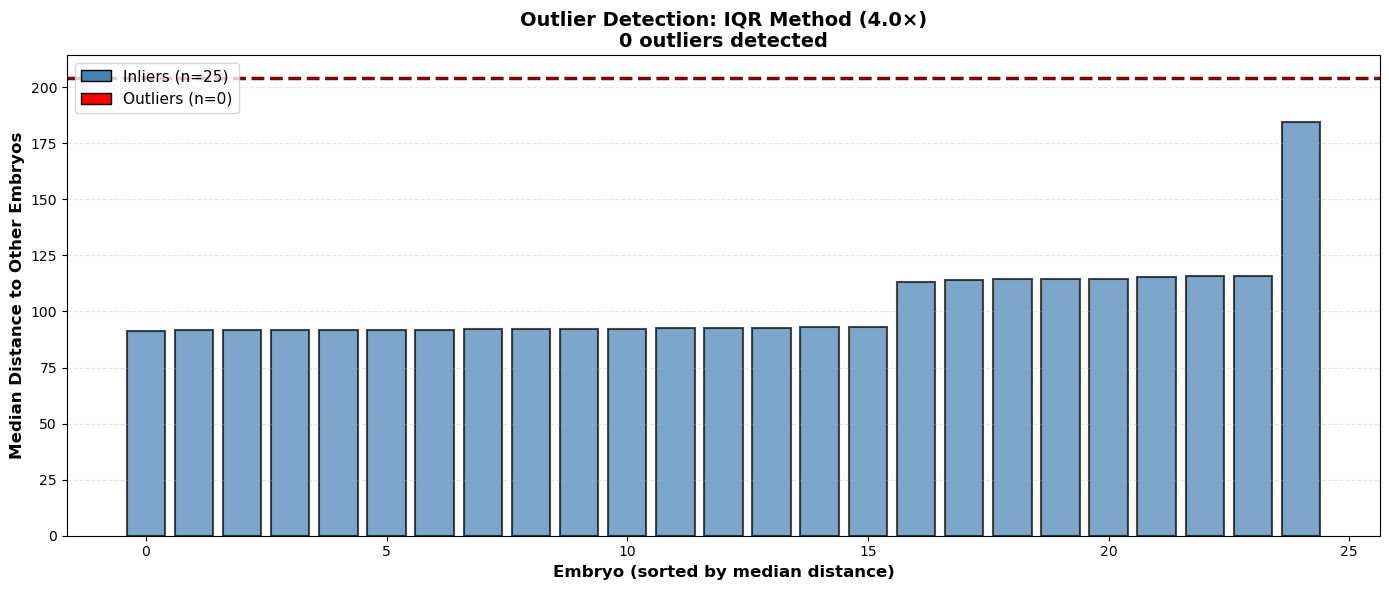

✓ Outlier visualization complete


In [7]:
# Visualize outlier detection: Bar plot with threshold
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by median distance
sorted_idx = np.argsort(median_distances)
sorted_dists = median_distances[sorted_idx]
sorted_embryo_ids = [embryo_ids[i] for i in sorted_idx]

# Create outlier mask for sorted data
outlier_mask = np.array([sorted_embryo_ids[i] in outlier_ids_iqr for i in range(len(sorted_embryo_ids))])

# Plot bars
colors = ['red' if is_outlier else 'steelblue' for is_outlier in outlier_mask]
ax.bar(range(len(sorted_dists)), sorted_dists, color=colors, edgecolor='black', alpha=0.7, linewidth=1.5)

# Threshold line
threshold_iqr = outlier_info_iqr['threshold']
ax.axhline(threshold_iqr, color='darkred', linestyle='--', linewidth=2.5, label=f'IQR Threshold = {threshold_iqr:.2f}')

# Labels and formatting
ax.set_xlabel('Embryo (sorted by median distance)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Distance to Other Embryos', fontsize=12, fontweight='bold')
ax.set_title(f'Outlier Detection: IQR Method (4.0×)\n{len(outlier_ids_iqr)} outliers detected', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label=f'Inliers (n={len(inlier_ids_iqr)})'),
    Patch(facecolor='red', edgecolor='black', label=f'Outliers (n={len(outlier_ids_iqr)})')
]
ax.legend(handles=legend_elements, fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

print(f"✓ Outlier visualization complete")

In [8]:
# Option: Remove outliers and create clean distance matrix
D_clean, embryo_ids_clean, outlier_info = remove_outliers_from_distance_matrix(
    D,
    embryo_ids,
    outlier_detection_method='iqr',
    outlier_threshold=4.0,  # IQR multiplier
    verbose=True
)

# Use cleaned data for rest of analysis
D_for_clustering = D_clean
embryo_ids_for_clustering = embryo_ids_clean

# Uncomment below to use original data (including outliers)
# D_for_clustering = D
# embryo_ids_for_clustering = embryo_ids

print(f"\n✓ Ready for clustering with {len(embryo_ids_for_clustering)} embryos")


Identifying outliers using 'iqr' method...
  Total embryos: 25
  Q1 (25th percentile): 91.918
  Q3 (75th percentile): 114.331
  IQR: 22.412
  IQR multiplier: 4.0×
  Threshold (Q3 + 4.0×IQR): 203.981
  Threshold: 203.981
  Outliers detected: 0
  Inliers retained: 25

✓ Outliers removed
  Original size: (25, 25)
  Clean size: (25, 25)

✓ Ready for clustering with 25 embryos


## Step 5a: Generate Dendrograms (K Selection)

Generate hierarchical clustering dendrograms with multiple K values to select optimal K.

**Two approaches available:**

### Approach 1: Basic Dendrogram (Clean K selection)
Use `generate_dendrograms()` to create a dendrogram with K cutoff lines:
- Shows clear cluster hierarchy
- Horizontal lines indicate where to cut for each K
- No category information, pure clustering structure
- Lightweight and easy to read

### Approach 2: Dendrogram with Category Bars (Context-aware)
Use `plot_dendrogram_with_categories()` to add colored bars showing experimental metadata:
- Same dendrogram as Approach 1
- Adds color bars below for pair, genotype, or other categories
- Helps you see if clusters match experimental design
- Better for presentation and interpretation

**Recommendation:** Generate both! Compare them side-by-side to understand cluster composition.

In [9]:
# Prepare category DataFrame for dendrogram visualization
# This maps embryo IDs to their experimental metadata
category_df = df_filtered[['embryo_id', 'pair', 'genotype']].drop_duplicates().reset_index(drop=True)
print(f"✓ Category DataFrame prepared: {len(category_df)} embryos")
print(f"  Categories: pair, genotype")

✓ Category DataFrame prepared: 25 embryos
  Categories: pair, genotype


Generating dendrogram...
  Embryos: 25
  Linkage method: average


  k=2: cutoff height=172.825, cluster sizes: {0: 24, 1: 1}
  k=3: cutoff height=116.959, cluster sizes: {0: 8, 1: 16, 2: 1}
  k=4: cutoff height=50.159, cluster sizes: {0: 8, 1: 8, 2: 8, 3: 1}
  k=5: cutoff height=7.826, cluster sizes: {0: 7, 1: 1, 2: 8, 3: 8, 4: 1}
✓ Dendrogram generated


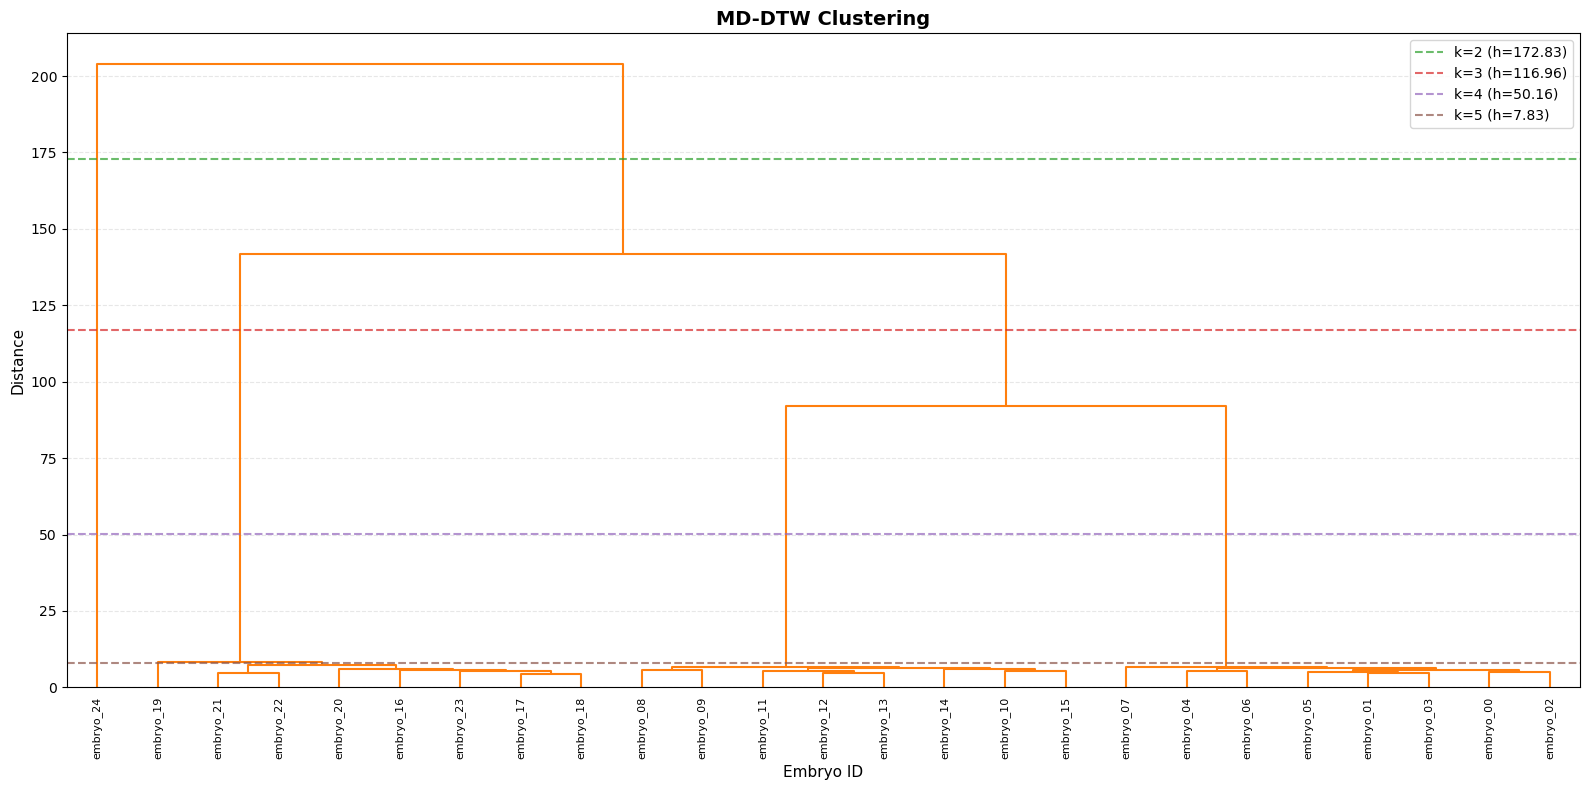

Generating dendrogram with category bars...
  Embryos: 25
  Categories: ['pair', 'genotype']
  Linkage method: average
  'pair': 4 unique values: ['pair_0', 'pair_1', 'pair_2', 'pair_outlier']
  'genotype': 3 unique values: ['b9d2_mutant', 'outlier', 'wildtype']


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/analyze/trajectory_analysis/dendrogram.py:672: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Dendrogram with categories generated


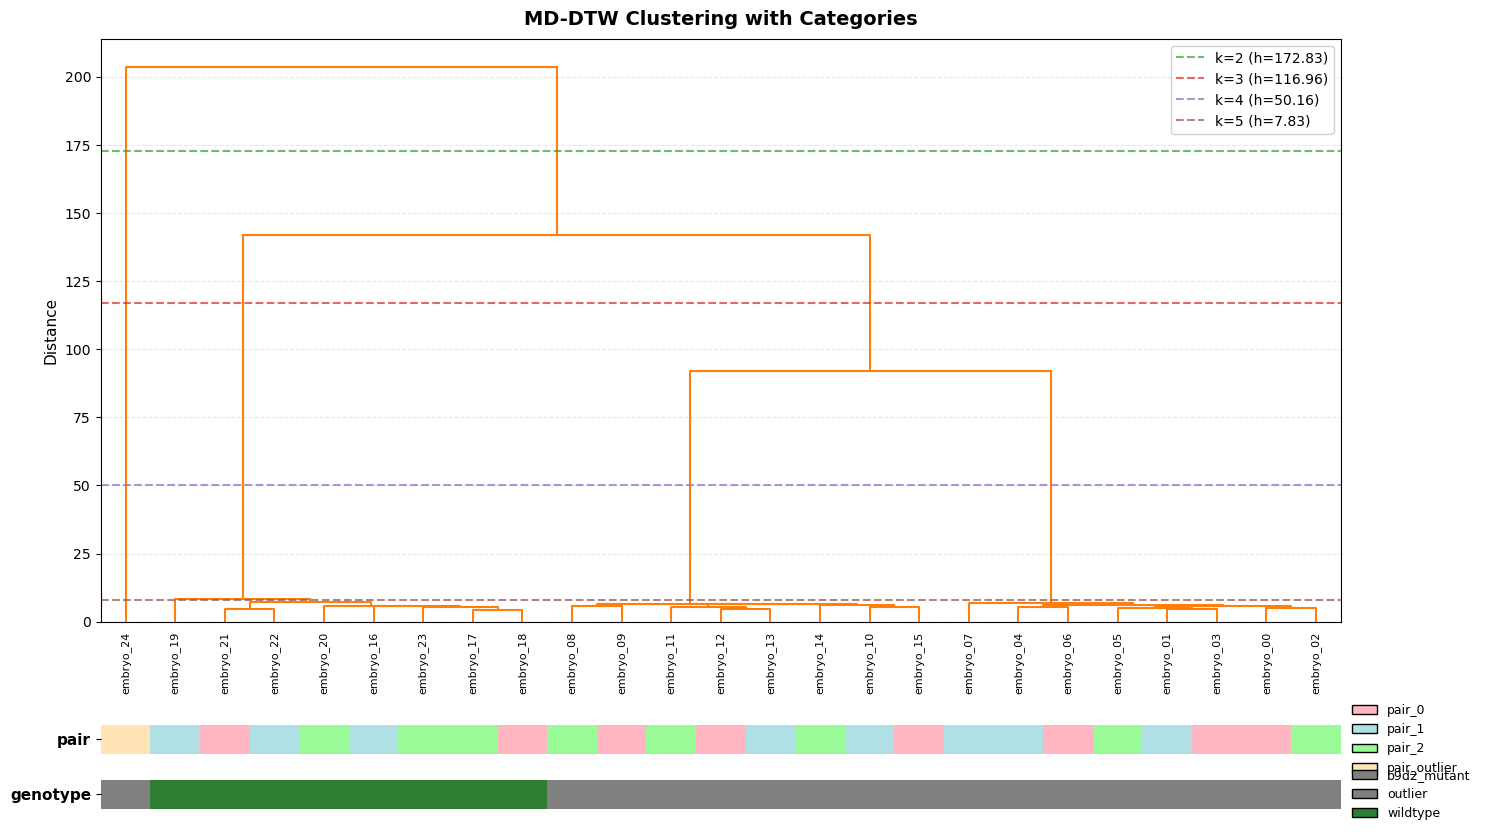


✓ Dendrograms generated successfully
  Available K values: [2, 3, 4, 5]

Cluster sizes by K:
  k=2: {0: 24, 1: 1}
  k=3: {0: 8, 1: 16, 2: 1}
  k=4: {0: 8, 1: 8, 2: 8, 3: 1}
  k=5: {0: 7, 1: 1, 2: 8, 3: 8, 4: 1}


In [10]:
# ============================================================================
# OPTION 1: Generate basic dendrogram
# ============================================================================

# Generate basic dendrogram with K cutoff lines
fig_basic, dendro_info = generate_dendrograms(
    D_for_clustering,
    embryo_ids_for_clustering,
    k_highlight=[2, 3, 4, 5],  # K values to show as cutoff lines
    linkage_method='average',
    title='MD-DTW Clustering',
    figsize=(16, 8),
    verbose=True
)
plt.show()

# ============================================================================
# OPTION 2: Generate dendrogram with category bars
# ============================================================================

# Import the function for category dendrograms if not already imported
from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# Generate dendrogram with categorical color bars
fig_cat, dendro_cat_info = plot_dendrogram_with_categories(
    D_for_clustering,
    embryo_ids_for_clustering,
    category_df=category_df,
    category_cols=['pair', 'genotype'],  # Show pair and genotype bars
    k_highlight=[2, 3, 4, 5],
    linkage_method='average',
    title='MD-DTW Clustering with Categories',
    figsize=(16, 10),
    spacer_height=0.7,  # Adjust if labels overlap with bars
    verbose=True
)
plt.show()

print(f"\n✓ Dendrograms generated successfully")
print(f"  Available K values: {list(dendro_info['embryo_to_cluster'].keys())}")

# Show cluster sizes by K value
print("\nCluster sizes by K:")
for k in sorted(dendro_info['embryo_to_cluster'].keys()):
    cluster_labels = dendro_info['cluster_labels'][k]
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"  k={k}: {dict(zip(unique, counts))}")

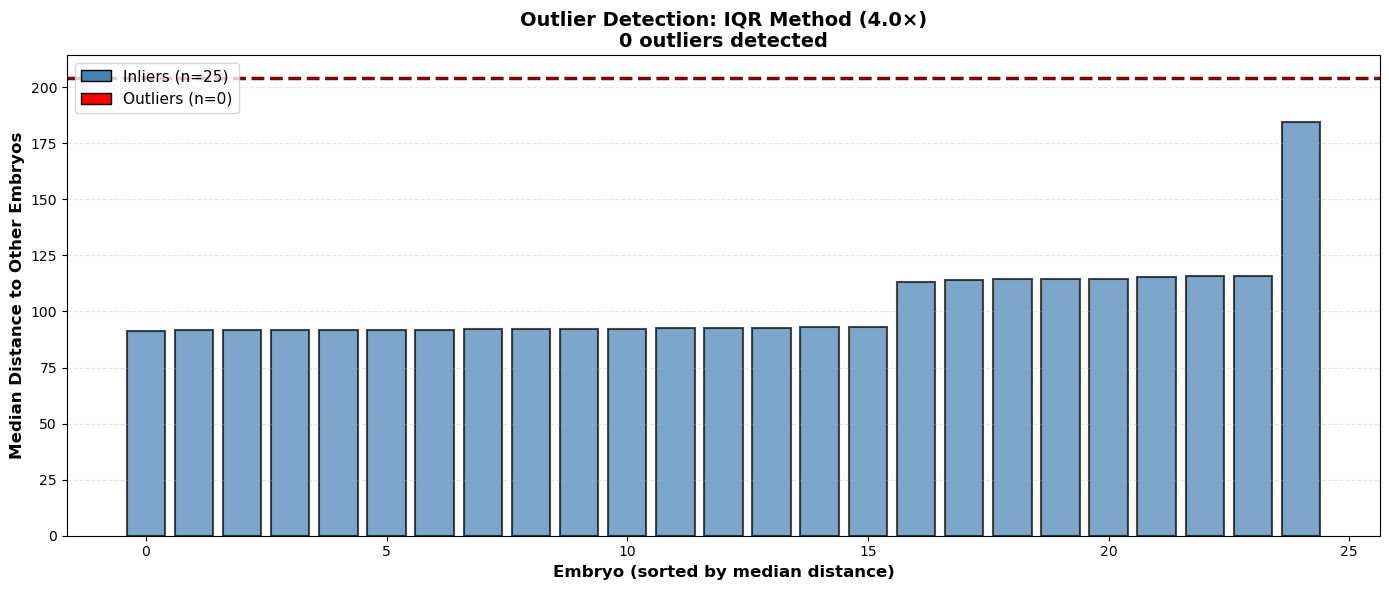

In [11]:


from typing import List, Optional, Tuple

def plot_outlier_detection(
    median_distances: np.ndarray,
    embryo_ids: List[str],
    outlier_ids: List[str],
    threshold: float,
    method: str = 'iqr',
    multiplier: Optional[float] = None,
    figsize: Tuple[int, int] = (14, 6),
    title: Optional[str] = None,
) -> plt.Figure:
    """Plot median distance bar chart with outlier detection threshold.
    
    Visualizes the distribution of median distances across embryos, highlighting
    outliers detected by the specified method.
    
    Args:
        median_distances: Array of median distances for each embryo
        embryo_ids: List of embryo IDs (same order as median_distances)
        outlier_ids: List of embryo IDs identified as outliers
        threshold: Detection threshold value
        method: Detection method used ('iqr', 'percentile', 'mad', 'median_distance')
        multiplier: Method-specific multiplier (e.g., IQR multiplier)
        figsize: Figure size (width, height)
        title: Custom title (auto-generated if None)
        
    Returns:
        Matplotlib figure
        
    Example:
        >>> median_dists = np.array([2.1, 2.3, 5.8, 2.0, 2.4])
        >>> embryo_ids = ['e1', 'e2', 'e3', 'e4', 'e5']
        >>> outliers = ['e3']
        >>> fig = plot_outlier_detection(
        ...     median_dists, embryo_ids, outliers,
        ...     threshold=4.5, method='iqr', multiplier=4.0
        ... )
    """
    from matplotlib.patches import Patch
    
    # Sort by median distance
    sorted_idx = np.argsort(median_distances)
    sorted_dists = median_distances[sorted_idx]
    sorted_embryo_ids = [embryo_ids[i] for i in sorted_idx]
    
    # Create outlier mask for sorted data
    outlier_mask = np.array([eid in outlier_ids for eid in sorted_embryo_ids])
    n_outliers = len(outlier_ids)
    n_inliers = len(embryo_ids) - n_outliers
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars
    colors = ['red' if is_outlier else 'steelblue' for is_outlier in outlier_mask]
    ax.bar(range(len(sorted_dists)), sorted_dists, color=colors, 
           edgecolor='black', alpha=0.7, linewidth=1.5)
    
    # Threshold line
    threshold_label = f'{method.upper()} Threshold = {threshold:.2f}'
    if multiplier is not None and method == 'iqr':
        threshold_label = f'IQR Threshold ({multiplier}×) = {threshold:.2f}'
    ax.axhline(threshold, color='darkred', linestyle='--', 
               linewidth=2.5, label=threshold_label)
    
    # Labels and formatting
    ax.set_xlabel('Embryo (sorted by median distance)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Median Distance to Other Embryos', fontsize=12, fontweight='bold')
    
    # Auto-generate title if not provided
    if title is None:
        method_name = method.upper()
        if method == 'iqr' and multiplier is not None:
            method_name = f'IQR Method ({multiplier}×)'
        title = f'Outlier Detection: {method_name}\n{n_outliers} outliers detected'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Color legend
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label=f'Inliers (n={n_inliers})'),
        Patch(facecolor='red', edgecolor='black', label=f'Outliers (n={n_outliers})')
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc='upper left')
    
    plt.tight_layout()
    
    return fig

# Use the function
fig = plot_outlier_detection(
    median_distances=median_distances,
    embryo_ids=embryo_ids,
    outlier_ids=outlier_ids_iqr,
    threshold=outlier_info_iqr['threshold'],
    method='iqr',
    multiplier=4.0,
    figsize=(14, 6)
)
plt.show()

In [12]:
# ============================================================================
# OPTION 2: Individual Functions (More Control) - Uncomment to use
# ============================================================================

# Import additional functions if not already imported
from src.analyze.trajectory_analysis import (
    plot_dendrogram,
    plot_dendrogram_with_categories,
)

# # Plot basic dendrogram
# fig_basic, dendro_info = plot_dendrogram(
#     D_for_clustering,
#     embryo_ids_for_clustering,
#     k_highlight=[2, 3, 4, 5],
#     linkage_method='average',
#     title='MD-DTW Hierarchical Clustering',
#     figsize=(16, 8),
#     verbose=True
# )
# plt.show()

# # Plot dendrogram with categories
# fig_cat, dendro_cat_info = plot_dendrogram_with_categories(
#     D_for_clustering,
#     embryo_ids_for_clustering,
#     category_df=category_df,
#     category_cols=['pair', 'genotype'],  # Set to None to turn off category bars
#     k_highlight=[2, 3, 4],
#     linkage_method='average',
#     title='MD-DTW Clustering with Categories',
#     figsize=(16, 10),
#     spacer_height=0.7,
#     verbose=True
# )
# plt.show()

# # Access cluster assignments from dendro_info
# print("\n✓ Dendrograms generated (Option 2: Individual functions)")
# print(f"  Available K values: {list(dendro_info['cluster_assignments'].keys())}")
# for k, labels in dendro_info['cluster_assignments'].items():
#     unique, counts = np.unique(labels, return_counts=True)
#     print(f"  k={k}: {dict(zip(unique, counts))}")

print("\n💡 Tip: Both Option 1 and Option 2 give you the same results!")
print("   Option 1 (generate_dendrograms) is just a convenience wrapper")
print("   Option 2 (individual functions) gives more fine-grained control")


💡 Tip: Both Option 1 and Option 2 give you the same results!
   Option 1 (generate_dendrograms) is just a convenience wrapper
   Option 2 (individual functions) gives more fine-grained control


## Step 5b: Extract Cluster Assignments

Add cluster assignments to your DataFrame using either:
- **Option 1:** Use `add_cluster_column()` helper (one line, handles missing embryos)
- **Option 2:** Manual mapping with dict (more explicit, gives you control)

Both are shown below - pick whichever you prefer!

In [13]:
# Choose K based on dendrogram inspection
k_selected = 3  # Change based on your dendrogram

# ============================================================================
# OPTION 1: Use add_cluster_column() helper (Recommended)
# ============================================================================
df_with_clusters = add_cluster_column(
    df_filtered,
    dendro_info=dendro_info,  # Pass the full info dict from generate_dendrograms()
    k=k_selected,
    column_name='md_dtw_cluster'
)

# ============================================================================
# OPTION 2: Manual mapping (Alternative - uncomment to use)
# ============================================================================
# # If using individual functions, extract cluster assignments from dendro_info
# cluster_labels = dendro_info['cluster_labels'][k_selected]
# cluster_lookup = dict(zip(embryo_ids_for_clustering, cluster_labels))
# 
# # Add to DataFrame
# df_with_clusters = df_filtered.copy()
# df_with_clusters['md_dtw_cluster'] = df_with_clusters['embryo_id'].map(cluster_lookup)

print(f"✓ Cluster assignments added for k={k_selected}")
print(f"  Column name: 'md_dtw_cluster'")

# Check cluster distribution
print(f"\nCluster distribution:")
cluster_summary = df_with_clusters.groupby('md_dtw_cluster')['embryo_id'].nunique()
print(cluster_summary)

# Check genotype distribution per cluster
print(f"\nGenotype distribution per cluster:")
genotype_by_cluster = df_with_clusters.groupby(['md_dtw_cluster', 'genotype'])['embryo_id'].nunique().unstack(fill_value=0)
print(genotype_by_cluster)

✓ Cluster assignments added for k=3
  Column name: 'md_dtw_cluster'

Cluster distribution:
md_dtw_cluster
0     8
1    16
2     1
Name: embryo_id, dtype: int64

Genotype distribution per cluster:
genotype        b9d2_mutant  outlier  wildtype
md_dtw_cluster                                
0                         0        0         8
1                        16        0         0
2                         0        1         0


## Step 5c: Plot Trajectories by Cluster

Visualize the actual trajectories colored by cluster assignment.

**New color logic (FIXED):**
- When `col_by='cluster'` or `color_by='cluster'`: Uses simple color palette (perfect for cluster numbers)
- When `col_by='genotype'` or `color_by='genotype'`: Uses custom genotype colors
- No more incorrect color mapping!

**Useful for:**
- Understanding what phenotypic differences define each cluster
- Validating cluster assignments match biology
- Generating publication-quality figures

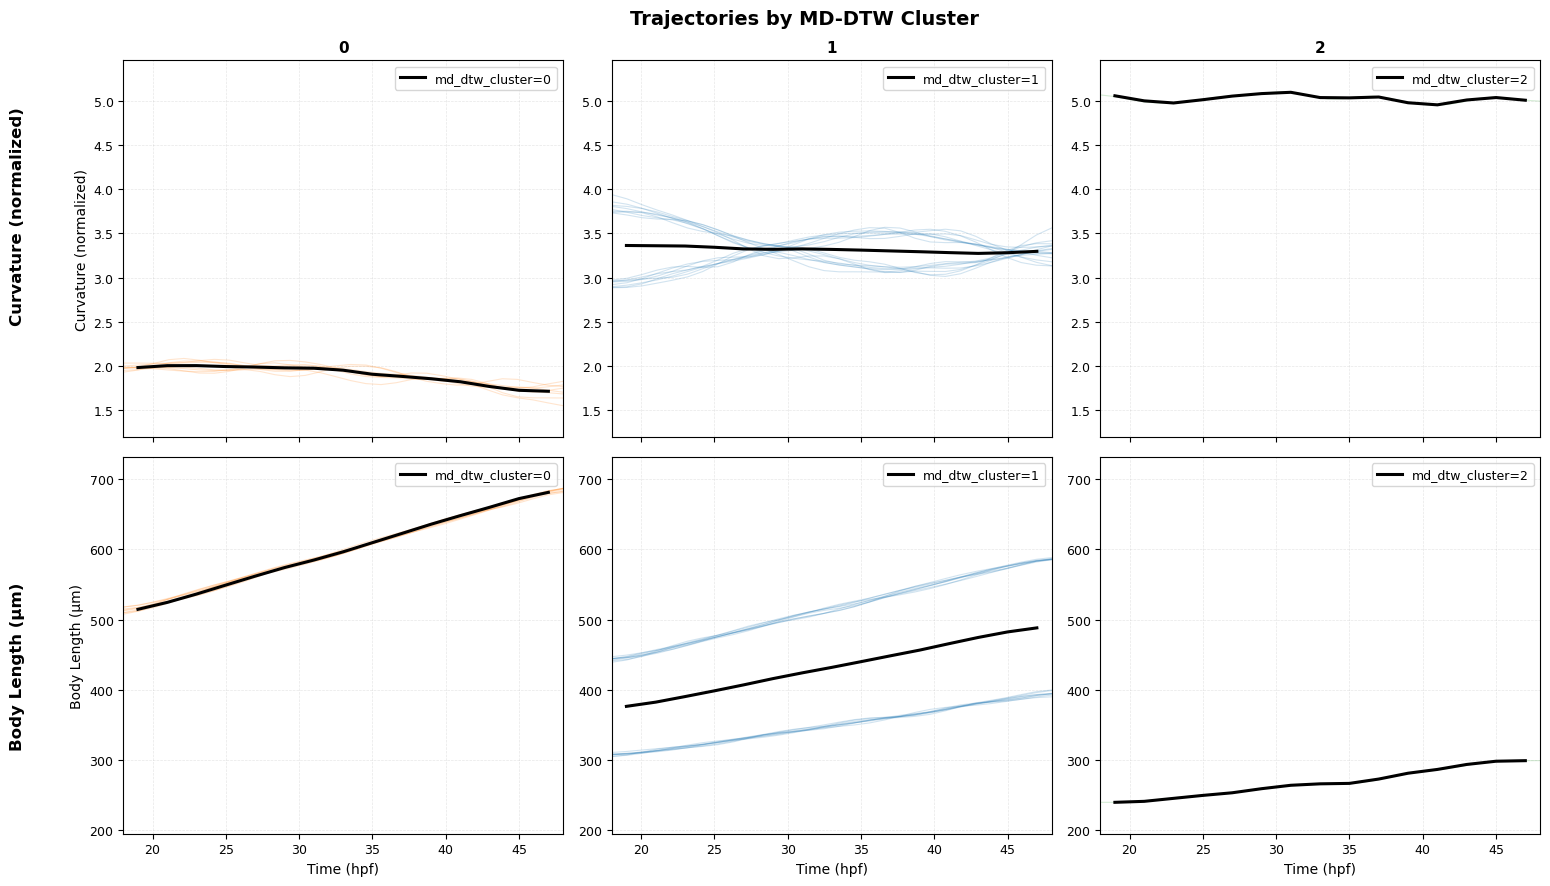

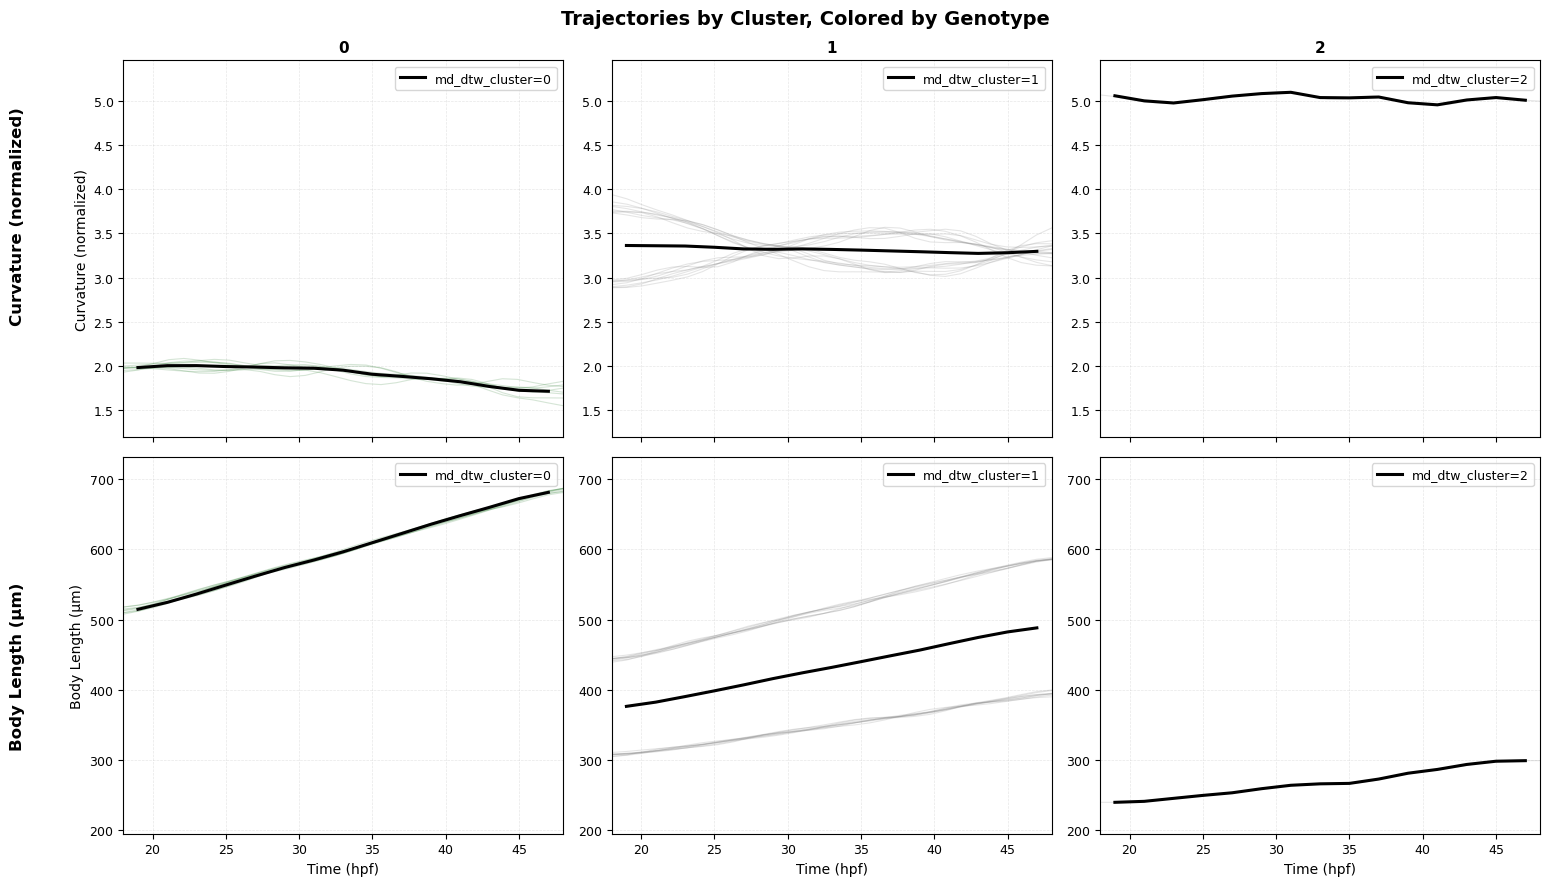

In [14]:
# Plot multimetric trajectories (metrics in rows, clusters in columns)
# Color logic: cluster numbers use simple palette, genotypes use custom colors
fig_trajectories = plot_multimetric_trajectories(
    df_with_clusters,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='md_dtw_cluster',  # Separate plot per cluster
    color_by='md_dtw_cluster',  # Color by cluster (uses simple palette - FIXED!)
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title='Trajectories by MD-DTW Cluster',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

plt.tight_layout()
plt.show()

# Optional: Color by genotype instead to validate clusters separate genotypes
fig_by_genotype = plot_multimetric_trajectories(
    df_with_clusters,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='md_dtw_cluster',
    color_by='genotype',  # Color by genotype (uses custom genotype colors)
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title='Trajectories by Cluster, Colored by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

plt.tight_layout()
plt.show()

# Optional: Save figures
# fig_trajectories.savefig('output/md_dtw_trajectories_by_cluster.png', dpi=300, bbox_inches='tight')
# fig_by_genotype.savefig('output/md_dtw_trajectories_by_genotype.png', dpi=300, bbox_inches='tight')

## Optional: Bootstrap Consensus Clustering

For more robust clustering, use bootstrap consensus clustering to assess stability.

**When to use:**
- You want confidence in cluster assignments
- You need to identify ambiguous embryos
- Publication-quality analysis

In [1]:
# Bootstrap hierarchical clustering
bootstrap_results = run_bootstrap_hierarchical(
    D_for_clustering,
    k=k_selected,
    embryo_ids=embryo_ids_for_clustering,
    n_bootstrap=100,  # 100 bootstrap iterations (increase for production)
    linkage_method='average',
    verbose=True
)

# Analyze posterior probabilities
posteriors = analyze_bootstrap_results(bootstrap_results)

print(f"\n✓ Bootstrap analysis complete")
print(f"  Posterior probabilities computed for {len(posteriors['embryo_ids'])} embryos")
print(f"\nPosterior probability summary:")
print(f"  Mean max_p: {posteriors['max_p'].mean():.3f}")
print(f"  Median max_p: {np.median(posteriors['max_p']):.3f}")
print(f"  Min max_p: {posteriors['max_p'].min():.3f}")

# Show embryos with low confidence (max_p < 0.7)
low_confidence = posteriors['max_p'] < 0.7
if low_confidence.any():
    print(f"\nLow confidence assignments (max_p < 0.7):")
    low_conf_ids = [posteriors['embryo_ids'][i] for i in np.where(low_confidence)[0]]
    print(f"  {low_conf_ids}")

NameError: name 'run_bootstrap_hierarchical' is not defined

## Summary & Next Steps

You've completed the MD-DTW analysis workflow with the **NEW API**! Here's what you did:

1. ✓ Loaded trajectory data
2. ✓ Prepared multivariate array with normalization
3. ✓ Computed MD-DTW distance matrix
4. ✓ Detected outliers using IQR method with visualization
5. ✓ Generated dendrograms with **`generate_dendrograms()`** - unified API
6. ✓ Added cluster assignments with **`add_cluster_column()`** - one-line helper
7. ✓ Plotted trajectories by cluster with **FIXED color logi
### Next Steps:

- **Save results**: Export cluster assignments and figures
- **Biological interpretation**: What do the clusters represent biologically?
- **Statistical testing**: Compare clusters using permutation tests
- **Refine analysis**: Adjust K, try different metrics, filter time ranges

### Saving Results:

In [ ]:
# Create output directory
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Save cluster assignments (using dendro_info from generate_dendrograms)
cluster_assignments = pd.DataFrame({
    'embryo_id': embryo_ids_for_clustering,
    'cluster': [dendro_info['embryo_to_cluster'][k_selected][eid] for eid in embryo_ids_for_clustering],
})
cluster_assignments.to_csv(output_dir / 'md_dtw_cluster_assignments.csv', index=False)
print(f"✓ Saved cluster assignments to {output_dir / 'md_dtw_cluster_assignments.csv'}")

# Save distance matrix
np.save(output_dir / 'md_dtw_distance_matrix.npy', D_for_clustering)
print(f"✓ Saved distance matrix to {output_dir / 'md_dtw_distance_matrix.npy'}")

# Save DataFrame with clusters
df_with_clusters.to_parquet(output_dir / 'trajectories_with_clusters.parquet')
print(f"✓ Saved trajectories with clusters to {output_dir / 'trajectories_with_clusters.parquet'}")

# Save dendrogram figures
fig_basic.savefig(output_dir / 'dendrogram_basic.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved dendrogram_basic.png")

fig_cat.savefig(output_dir / 'dendrogram_with_categories.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved dendrogram_with_categories.png")

print("\n✓ All results saved!")

## Tips & Troubleshooting

### Choosing K:
- Look for large vertical gaps in dendrogram (natural cluster boundaries)
- Avoid K values that create many singleton clusters
- Consider biological context (how many phenotypes do you expect?)
- Use bootstrap consensus to assess stability across K values

### Outlier Detection (IQR Method):
- **IQR multiplier 4.0×**: Extreme outlier detection (conservative, few outliers)
- **IQR multiplier 3.0×**: Strong outlier detection
- **IQR multiplier 1.5×**: Standard outlier detection (more aggressive)
- Review outlier embryos manually before excluding them
- Consider if outliers are biological (true rare phenotype) or technical

### Metric Selection:
- Use metrics that capture phenotypic variation you care about
- Combine shape (curvature) + size (length) for comprehensive analysis
- Always use `normalize=True` to ensure equal weighting

### Sakoe-Chiba Radius:
- `radius=3`: Good default (slight temporal flexibility)
- Increase if embryos develop at slightly different rates
- Decrease if you want strict temporal alignment

### Performance:
- MD-DTW is O(N² × T²) where N=embryos, T=timepoints
- For 50 embryos × 50 timepoints: ~30 seconds
- For 100+ embryos: consider filtering or sampling